https://chat.deepseek.com/a/chat/s/b693a3a0-dd59-4cc2-b6b7-67484f101d65

In [1]:
from data_loader import load_data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import warnings
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

warnings.filterwarnings(action='ignore')

### 1. Load the data from data `data_loader`:

In [2]:
df = load_data()
df.head(3)

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,...,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes


### 2. EDA:

In [3]:
print(f"There are total of {df.shape[0]} samples and {df.shape[1]} features.")

There are total of 7043 samples and 21 features.


`customer_id` won't be relevant for us, so for now we will drop it.

In [4]:
df = df.drop(columns=['customer_id'])

In [5]:
df.shape

(7043, 20)

In [6]:
df.isna().sum()

gender               0
senior_citizen       0
partner              0
dependents           0
tenure               0
phone_service        0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
contract             0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
churn                0
dtype: int64

We don't have any missing values.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   gender             7043 non-null   object
 1   senior_citizen     7043 non-null   int64 
 2   partner            7043 non-null   object
 3   dependents         7043 non-null   object
 4   tenure             7043 non-null   int64 
 5   phone_service      7043 non-null   object
 6   multiple_lines     7043 non-null   object
 7   internet_service   7043 non-null   object
 8   online_security    7043 non-null   object
 9   online_backup      7043 non-null   object
 10  device_protection  7043 non-null   object
 11  tech_support       7043 non-null   object
 12  streaming_tv       7043 non-null   object
 13  streaming_movies   7043 non-null   object
 14  contract           7043 non-null   object
 15  paperless_billing  7043 non-null   object
 16  payment_method     7043 non-null   object


#### 2.1 Univariate Analysis:

In [8]:
df.value_counts('churn')

churn
No     5174
Yes    1869
Name: count, dtype: int64

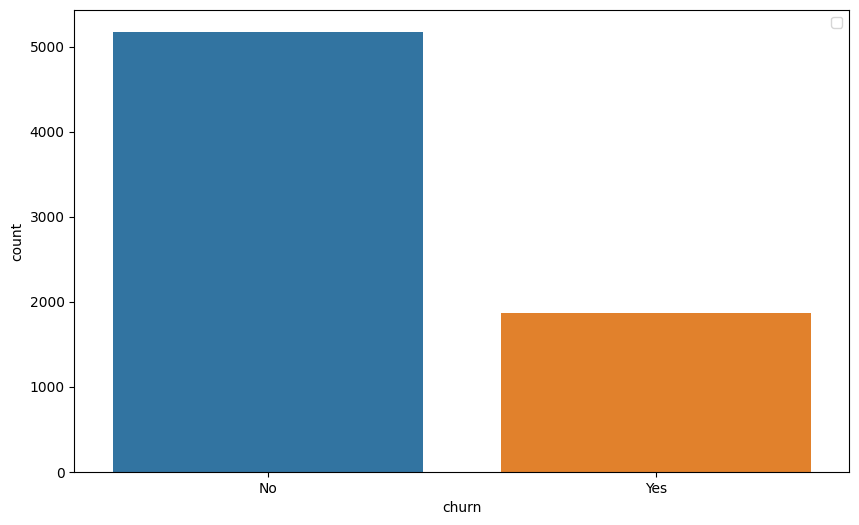

In [9]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='churn', hue='churn')
plt.legend()  
plt.show()

There is an imbalance in the dataset.

So, we will be using this dataset of 3 versions i.e.:
1. The original format
2. Undersampling (Bring down the data of high label count to low label coun)
3. Oversampling (Increase the data of low label count to match the count of the data of the high label.)

and then compare the accuracies and move forward accordingly.

In [10]:
df.head(2)

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No


Converting data types for `monthly_charges` and `total_charges`:

In [11]:
df['monthly_charges'] = pd.to_numeric(df['monthly_charges'], errors='coerce')
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')

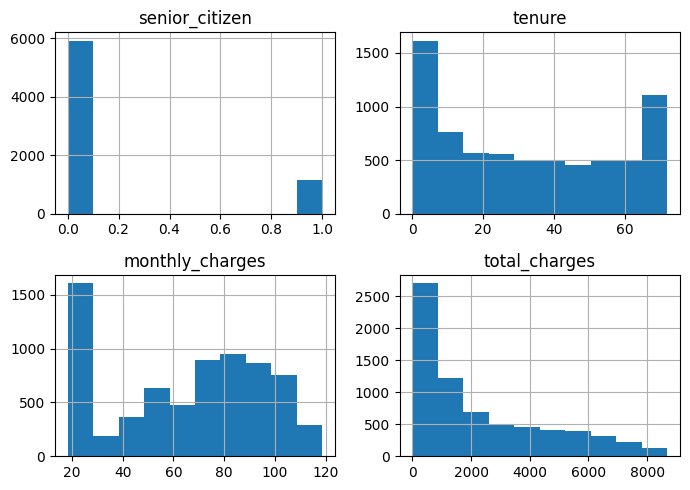

In [12]:
df.hist(figsize=(7, 5))
plt.tight_layout()
plt.show()

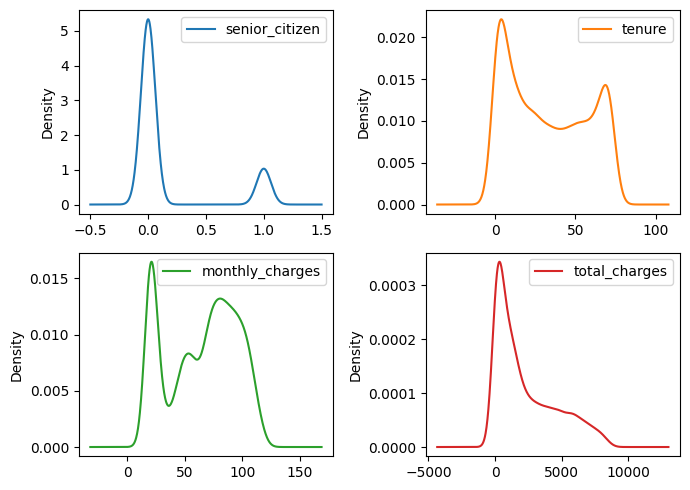

In [13]:
df.plot(kind='density', subplots=True, layout=(2, 2), figsize=(7, 5), sharex=False)
plt.tight_layout()
plt.show()

We can see that most of the clients are young.

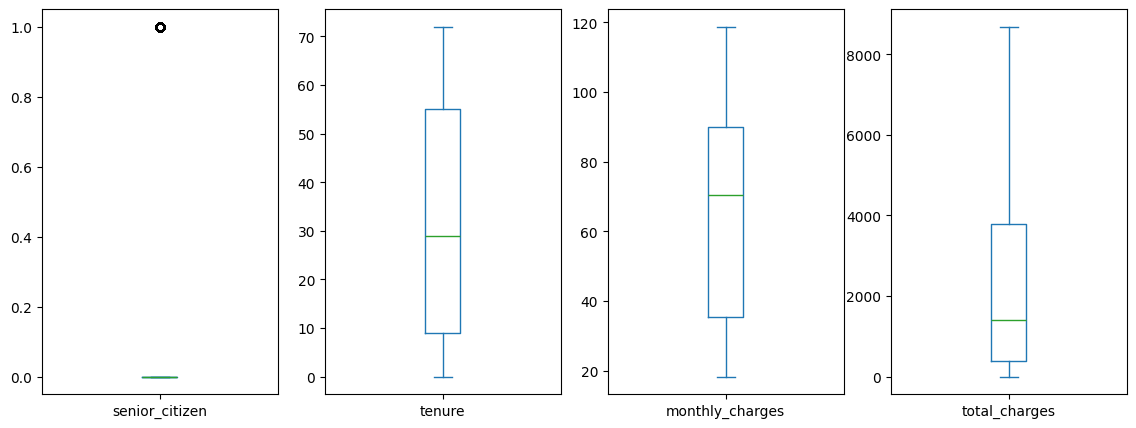

In [14]:
df.plot(kind='box', subplots=True, sharex=False, sharey=False, figsize=(14, 5))
plt.show()

### Gender:

Customer involvement by gender:

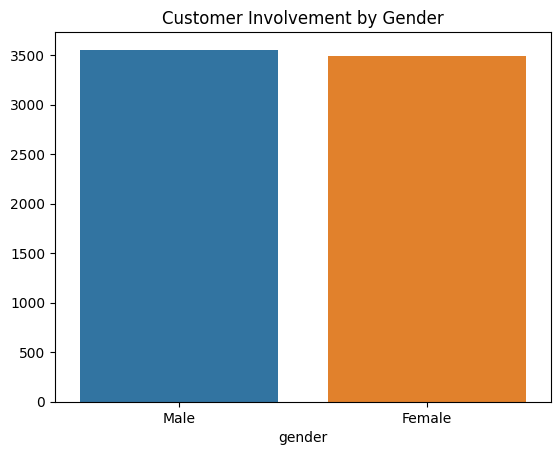

In [15]:
sns.barplot(x=df['gender'].value_counts().index, 
            y=df['gender'].value_counts().values, 
            hue=df['gender'].value_counts().index)
plt.title("Customer Involvement by Gender")
plt.show()

### Contract:

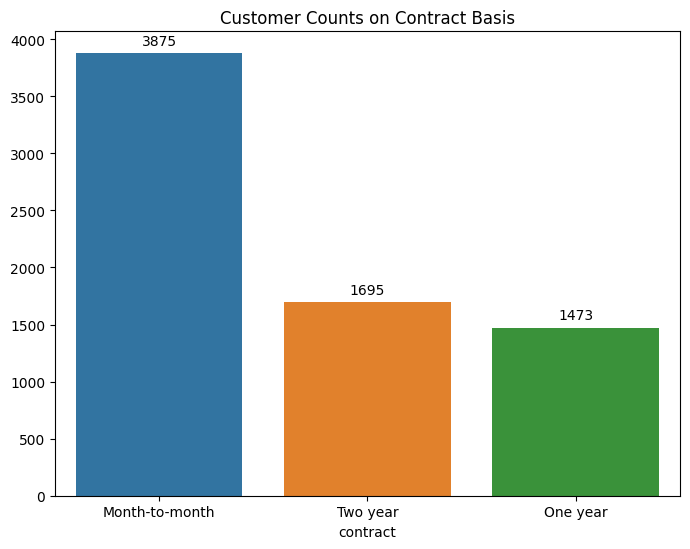

In [16]:
plt.figure(figsize=(7, 5.6))
ax = sns.barplot(x=df['contract'].value_counts().index,
                 y=df['contract'].value_counts().values,
                 hue=df['contract'].value_counts().index
                )


for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 9), textcoords='offset points')

plt.title("Customer Counts on Contract Basis")
plt.tight_layout()
plt.show()

This dataset has no any date columns else we could assume how long they have been in the business. If it has been for a short time then this chart shows the company is doing well as the contract for one year and two years are there which shows some level of trust and satisfaction but if the company is old then we need to come up with some strategies to turn customers from month-to-month subscription ot one or more year contract.

### Tenure:

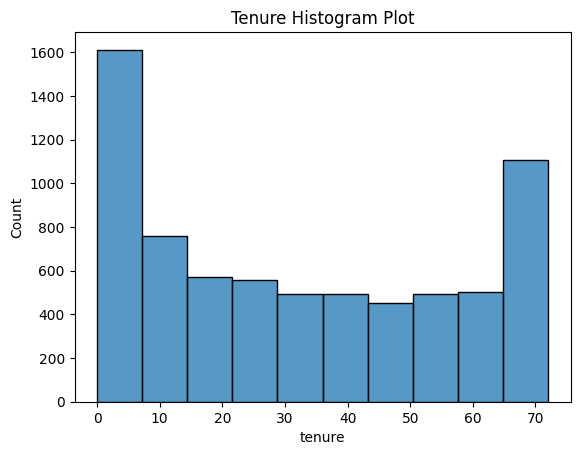

In [17]:
sns.histplot(df['tenure'], bins=10)
plt.title("Tenure Histogram Plot")
plt.show()

Here, is an interesting pattern, there are customers who have been with the company for past 70 months, and there are new batch of customer who are at their first experience ranging from their first to their fifth month of subscription. So, this shows, the company has been running their services for a long time and clears out doubt for earlier chart.

### Customer Marriage Status:

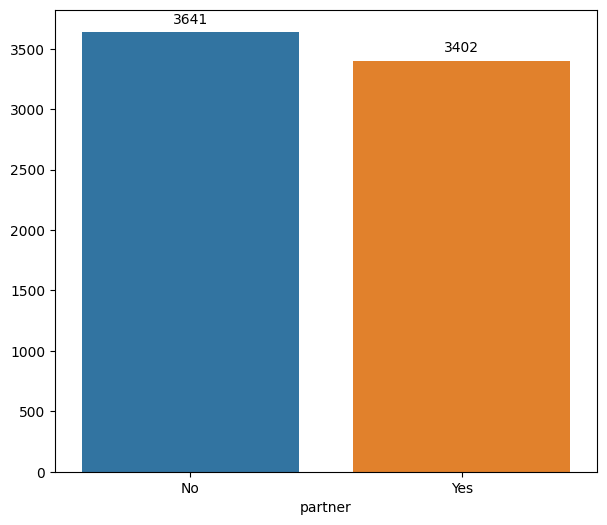

In [18]:
plt.figure(figsize=(7, 6))
ax = sns.barplot(x=df['partner'].value_counts().index,
                y=df['partner'].value_counts().values,
                hue=df['partner'].value_counts().index)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 9), textcoords='offset points')
    
plt.show()

## 3. Data Pre-processing:

### 3.1 Convert Churn column to binary data:

In [19]:
df['churn'] = df['churn'].map({"Yes": 1, "No":0})
df['churn'] = df['churn'].astype('object')
df['churn'].value_counts()

churn
0    5174
1    1869
Name: count, dtype: int64

Convert `senior_citizen` data type to object:

In [20]:
df['senior_citizen'] = df['senior_citizen'].astype('object')

In [21]:
df.head(2)

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0


### 3.2 Data Encoding:

In the categorical data that we have, there is no any Ordinal data, and these categorical columns also don't have too
much of cardinality, so, here I will be using `One-hot Encoding.`

In [63]:
df.head(2)

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0


#### Separate data into dependent and independent features:

In [55]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

Separate the categorical and numerical feauture for `Encoding` and calculating `Correlation and VIF`:

In [56]:
numerical_df = X.select_dtypes(include=['int64', 'float64'])

In [51]:
categorical_df = X.select_dtypes(include=['object'])
categorical_cols = categorical_df.columns
transformers = [(col, OneHotEncoder(), [col]) for col in categorical_cols]

column_transformer = ColumnTransformer(
    transformers=transformers, 
    remainder='passthrough'
)


encoded_data = column_transformer.fit_transform(X)  
encoded_df = pd.DataFrame(encoded_data, columns=column_transformer.get_feature_names_out())


### 3.3 Correlation and Multi-Collinearity:

#### Concate the numerical feature and the target label for correlation:

In [66]:
numerica_df_target = pd.concat([numerical_df, y], axis=1)

In [67]:
data_corr = numerica_df_target.corr()

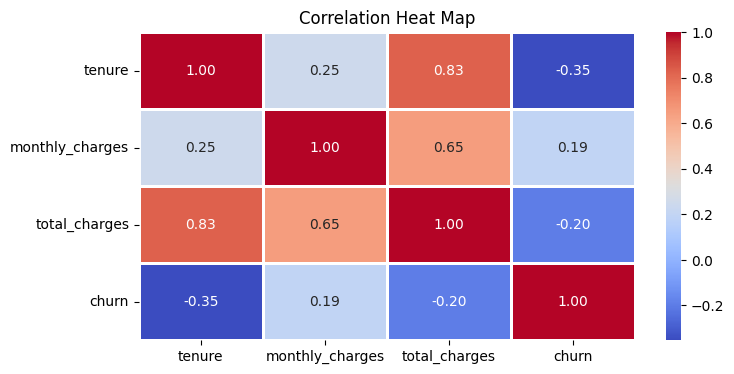

In [70]:
plt.figure(figsize=(8, 4))
sns.heatmap(data_corr, annot=True, fmt='.2f', linewidths=0.75, cmap='coolwarm')
plt.title('Correlation Heat Map')
plt.show()

In [81]:
vif_data = pd.DataFrame()
vif_data["feature"] = numerical_df.columns
vif_data["VIF"] = [variance_inflation_factor(numerical_df.values, i) for i in range(numerical_df.shape[1])]

vif_data

,feature,VIF
0,tenure,6.332328
1,monthly_charges,3.355660
2,total_charges,8.075070


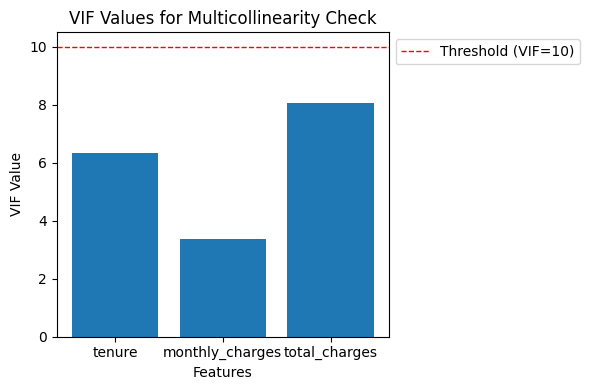

In [91]:
plt.figure(figsize=(6, 4))
plt.bar(x='feature', height='VIF', data=vif_data)
plt.title('VIF values for Mult-collinearity Check')
plt.axhline(y=10, color='red', linestyle='--', linewidth=1, label='Threshold (VIF=10)')
plt.xlabel("Features")
plt.ylabel("VIF Value")
plt.title("VIF Values for Multicollinearity Check")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

Here, the VIF values are < 10, so there is no any multi-collinearity.

## 4. Feature Scaling:

In [104]:
X_train, X_test, y_train, y_test = train_test_split(encoded_df, y, test_size=0.2, random_state=42)

In [105]:
X_train.head(1)

,gender__gender_Female,gender__gender_Male,senior_citizen__senior_citizen_0,senior_citizen__senior_citizen_1,partner__partner_No,partner__partner_Yes,dependents__dependents_No,dependents__dependents_Yes,phone_service__phone_service_No,phone_service__phone_service_Yes,...,contract__contract_Two year,paperless_billing__paperless_billing_No,paperless_billing__paperless_billing_Yes,payment_method__payment_method_Bank transfer (automatic),payment_method__payment_method_Credit card (automatic),payment_method__payment_method_Electronic check,payment_method__payment_method_Mailed check,remainder__tenure,remainder__monthly_charges,remainder__total_charges
2142,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,21.0,64.85,1336.8


In [106]:
numerical_columns = X_train.iloc[:, -3:].columns.to_list()

In [107]:
numerical_columns

['remainder__tenure', 'remainder__monthly_charges', 'remainder__total_charges']

In [108]:
column_transformer = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numerical_columns), 
    ],
    remainder='passthrough')

In [112]:
X_train_scaled = column_transformer.fit_transform(X_train)
scaled_col_names = column_transformer.get_feature_names_out()
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=scaled_col_names)

In [114]:
X_test_scaled = column_transformer.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=scaled_col_names)

## 5. Feature Selection: